In [2]:
import numpy as np
import matplotlib.pyplot as plt
# import mpl_toolkits.mplot3d.Axes3D
from transformers import DPTImageProcessor, DPTForDepthEstimation
import torch
from PIL import Image
import plotly.graph_objs as go



/home/codespace/.python/current/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:

# Load the image from the URL
url = "/workspaces/DepthMapExplorer-3DPointCloudLab/Images/Gita-Jayanti.jpg"
image = Image.open(url)

# Initialize the DPT model
processor = DPTImageProcessor.from_pretrained("Intel/dpt-large")
model = DPTForDepthEstimation.from_pretrained("Intel/dpt-large")


: 

In [ ]:

inputs = processor(images=image, return_tensors="pt")

# Model inference
with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

# Interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

# numpy array and normalize
depth_map = prediction.squeeze().cpu().numpy()
depth_map = (depth_map * 255 / np.max(depth_map)).astype("uint8")


NameError: name 'processor' is not defined

In [ ]:

image_np = np.array(image)

# Parameters
height, width = depth_map.shape
fx, fy = 525.0, 525.0  # Focal length
cx, cy = width / 2, height / 2  # Optical center


points = []
colors = []


In [ ]:

for v in range(height):
    for u in range(width):
        Z = depth_map[v, u]
        if Z == 0: continue  # Skip zero depth values
        X = (u - cx) * Z / fx
        Y = (v - cy) * Z / fy
        points.append([X, Y, Z])
        colors.append('rgb({},{},{})'.format(*image_np[v, u]))  # Convert to RGB string

points = np.array(points)


trace = go.Scatter3d(
    x=points[:, 0],
    y=points[:, 1],
    z=points[:, 2],
    mode='markers',
    marker=dict(
        size=1,
        color=colors,  # Set color to the RGB values
    )
)


data = [trace]

# Layout for 3D plot
layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0)
)

fig = go.Figure(data=data, layout=layout)
fig.write_html("3d_plot.html")


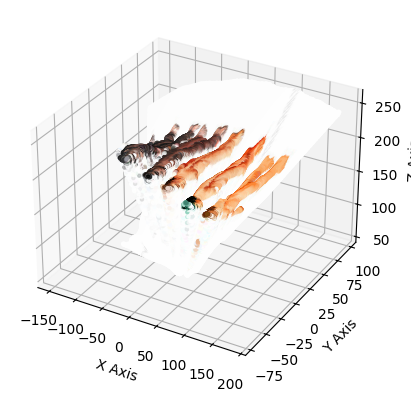

In [ ]:
# Convert image to numpy array
image_np = np.array(image)

# Parameters
height, width = depth_map.shape
fx, fy = 525.0, 525.0  # Focal length
cx, cy = width / 2, height / 2  # Optical center

# Accumulate points and colors
points = []
colors = []

for v in range(height):
    for u in range(width):
        Z = depth_map[v, u]
        if Z == 0: continue  # Skip zero depth values
        X = (u - cx) * Z / fx
        Y = (v - cy) * Z / fy
        points.append([X, Y, Z])
        colors.append(image_np[v, u] / 255)  # Normalize color values

points = np.array(points)
colors = np.array(colors)

# Create and visualize the point cloud using Matplotlib
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot all points in a single call
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors, marker='.')

# Set labels and show plot
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
plt.show()
